## 申请评分卡

In [325]:
#导入相关模块
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import pandasql
import missingno as msno
import scipy.stats.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
#忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [330]:
#读取数据
data = pd.read_csv('data_new.csv')
data.head()

,age,education,shebao,vehicle_num,income_range,loan_rate,seniority,client_type,label,zhima_score,gender_Female,gender_Male,marriage_marriage,marriage_unmarriage,house_nature_owned,house_nature_rent,house_nature_unknown,house_nature_with_parents,cv_ios,cv_other
0,33,2,1,0,4,0,4,1,0,781,0,1,0,1,1,0,0,0,0,1
1,24,3,0,0,1,1,1,2,0,705,1,0,0,1,0,1,0,0,0,1
2,40,2,1,0,4,1,2,2,0,798,0,1,1,0,1,0,0,0,0,1
3,35,1,1,0,4,1,4,2,0,676,0,1,1,0,1,0,0,0,0,1
4,24,2,0,0,2,1,1,2,0,753,1,0,0,1,0,1,0,0,0,1


In [331]:
data.shape

(728603, 20)

In [332]:
data.isnull().sum(axis=0)/len(data)

age                         0.00000
education                   0.00000
shebao                      0.00000
vehicle_num                 0.00000
income_range                0.00000
loan_rate                   0.00000
seniority                   0.00000
client_type                 0.00000
label                       0.00000
zhima_score                 0.00000
gender_Female               0.00000
gender_Male                 0.00000
marriage_marriage           0.00000
marriage_unmarriage         0.00000
house_nature_owned          0.00000
house_nature_rent           0.00000
house_nature_unknown        0.00000
house_nature_with_parents   0.00000
cv_ios                      0.00000
cv_other                    0.00000
dtype: float64

In [333]:
data.describe().to_excel("数据概述.xlsx")

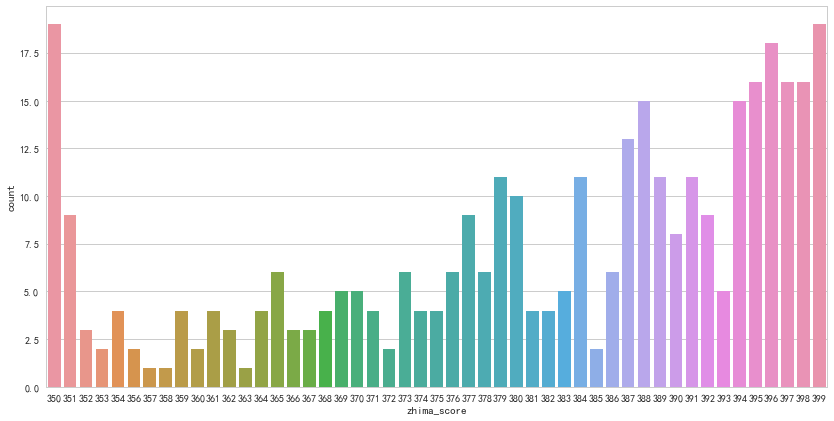

In [338]:
plt.figure(figsize=(14,7))
sns.countplot(x="zhima_score",data=data[data.zhima_score<400])

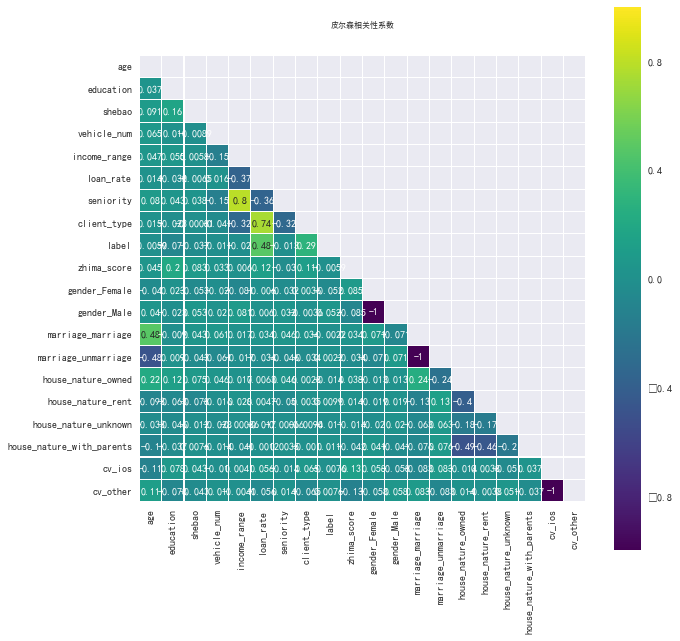

In [340]:
#皮尔森相关系数
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.set_style("dark",{"font.sans-serif":["simhei","Arial"]})
plt.title('皮尔森相关性系数', y=1.05, size=8)
mask = np.zeros_like(data.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True,mask=mask)

In [345]:
drop_col = ['seniority','gender_Male',  'marriage_unmarriage','loan_rate',"cv_other"]
data = data.drop(drop_col,axis=1)

In [346]:
col_feature = list(data.columns)
col_feature

['age',
 'education',
 'shebao',
 'vehicle_num',
 'income_range',
 'client_type',
 'label',
 'zhima_score',
 'gender_Female',
 'marriage_marriage',
 'house_nature_owned',
 'house_nature_rent',
 'house_nature_unknown',
 'house_nature_with_parents',
 'cv_ios']

In [353]:
data.columns = ["X1","X2","X3","X4","X5","X8","label","X9","X10", "X12", "X14","X15","X16","X17","X18"]

### 特征信息价值 IV=sum((goodattribute-badattribute)*ln(goodattribute/badattribute))
### 通过IV值判断变量预测能力的标准是：
###  <0.02: unpredictive
###  0.02 to 0.1: weak
####  0.1 to 0.3 : median
### 0.3 to 0.5: strong
#### > 0.5: suspicious

In [109]:
#连续特征分箱函数
def mono_bin(Y, X, n):
    r = 0
    good=Y.sum()
    bad=Y.count()-good
    while np.abs(r) < 1:
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        n = n - 1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min']=d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe']=np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d3['goodattribute']=d3['sum']/good
    d3['badattribute']=(d3['total']-d3['sum'])/bad
    #特征信息价值
    iv=((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    
    d4 = (d3.sort_index(by = 'min')).reset_index(drop=True)

    cut=[]
    cut.append(float('-inf'))
    
    for i in range(1,n+1):
        qua=X.quantile(i/(n+1))
        cut.append(round(qua,4))
        
    cut.append(float('inf'))
    
    woe=list(d4['woe'].round(3))
    
    #return d4,iv
    return cut,woe

In [124]:
#分类特征分箱函数
def self_bin(Y,X,cat):
    good=Y.sum()
    bad=Y.count()-good
    d1=pd.DataFrame({'X':X,'Y':Y,'Bucket':pd.cut(X,cat)})
    d2=d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.X.min(), columns=['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log((d3['rate'] / (1 - d3['rate'])) / (good / bad))
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    d4 = (d3.sort_index(by='min'))
    woe = list(d4['woe'].round(3))
    return iv,woe

In [349]:
pinf = float('inf')#正无穷大
ninf = float('-inf')#负无穷大

In [351]:
cutx1 = [ninf,20,30,40,pinf]
cutx2 = [0,1,2,3]
cutx3 = [0,1]
cutx4 = [0,1]
cutx5 = [0,1,2,3,4]

cutx8 = [1,2]
cutx9 = [ninf,550,650,750,pinf]
cutx10 = [0,1]

cutx12 = [0,1]

cutx14 = [0,1]
cutx15 = [0,1]
cutx16 = [0,1]
cutx17 = [0,1]
cutx18 = [0,1]


In [355]:
iv1,woe1 = self_bin(data.label,data.X1,cutx1)
iv2,woe2 = self_bin(data.label,data.X2,cutx2)
iv3,woe3 = self_bin(data.label,data.X3,cutx3)
iv4,woe4 = self_bin(data.label,data.X4,cutx4)
iv5,woe5 = self_bin(data.label,data.X5,cutx5)

iv8,woe8 = self_bin(data.label,data.X8,cutx8)
iv9,woe9 = self_bin(data.label,data.X9,cutx9)
iv10,woe10 = self_bin(data.label,data.X10,cutx10)

iv12,woe12 = self_bin(data.label,data.X12,cutx12)

iv14,woe14 = self_bin(data.label,data.X14,cutx14)
iv15,woe15 = self_bin(data.label,data.X15,cutx15)
iv16,woe16 = self_bin(data.label,data.X16,cutx16)
iv17,woe17 = self_bin(data.label,data.X17,cutx17)
iv18,woe18 = self_bin(data.label,data.X18,cutx18)

In [364]:
col_feature.remove("label")

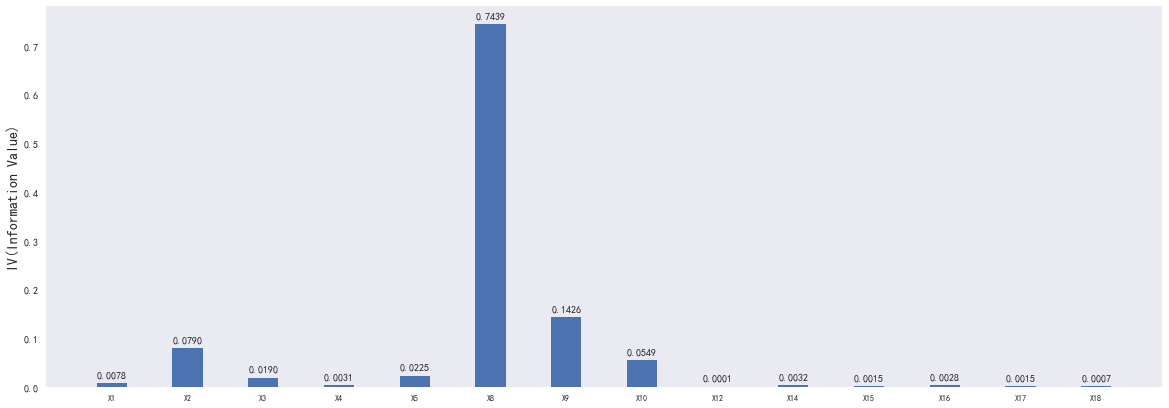

In [368]:
ivlist=[iv1,iv2,iv3,iv4,iv5,iv8,iv9,iv10,iv12,iv14,iv15,iv16,iv17,iv18]#各变量IV
index=data.drop("label",axis=1).columns #x轴的标签
fig1 = plt.figure(figsize=(20,7))
ax1 = fig1.add_subplot(1, 1, 1)
x = np.arange(len(index))+1
ax1.bar(x, ivlist, width=0.4)#生成柱状图
ax1.set_xticks(x)
ax1.set_xticklabels(index, rotation=0, fontsize=8)
ax1.set_ylabel('IV(Information Value)', fontsize=14)
#在柱状图上添加数字标签
for a, b in zip(x, ivlist):
    plt.text(a, b + 0.01, '%.4f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

In [370]:
#删除信息价值较低的特征阈值为0.02
drop_col = ["X1","X3","X4", "X12","X14","X15","X16","X17","X18"]
data = data.drop(drop_col,axis=1)

In [371]:
data.columns

Index(['X2', 'X5', 'X8', 'label', 'X9', 'X10'], dtype='object')

## 特征权重WOE 转换

In [372]:
#替换成woe函数
def replace_woe(series,cut,woe):
    list=[]
    i=0
    while i<len(series):
        value=series[i]
        j=len(cut)-2
        m=len(cut)-2
        while j>=0:
            if value>=cut[j]:
                j=-1
            else:
                j -=1
                m -= 1
        list.append(woe[m])
        i += 1
    return list

In [373]:
data.head()

,X2,X5,X8,label,X9,X10
0,2,4,1,0,781,0
1,3,1,2,0,705,1
2,2,4,2,0,798,0
3,1,4,2,0,676,0
4,2,2,2,0,753,1


In [374]:
data["X2"] = replace_woe(list(data.X2),cutx2,woe2)
data["X5"] = replace_woe(list(data.X5),cutx5,woe5)
data["X8"] = replace_woe(list(data.X8),cutx8,woe8)
data["X9"] = replace_woe(list(data.X9),cutx9,woe9)
data["X10"] = replace_woe(list(data.X10),cutx10,woe10)

In [375]:
data.head()

,X2,X5,X8,label,X9,X10
0,-1.32700,-0.39300,1.59900,0,-1.89600,-0.54000
1,-1.32700,0.05600,1.59900,0,-0.58800,-0.54000
2,-1.32700,-0.39300,1.59900,0,-1.89600,-0.54000
3,-0.79000,-0.39300,1.59900,0,-0.58800,-0.54000
4,-1.32700,-0.03100,1.59900,0,-1.89600,-0.54000


In [378]:
data[["X2","X5","X8","X9","X10"]].describe().T

,count,mean,std,min,25%,50%,75%,max
X2,728603.00000,-0.58860,0.35902,-1.32700,-0.79000,-0.27900,-0.27900,-0.27900
X5,728603.00000,-0.26514,0.20502,-0.47700,-0.47700,-0.39300,-0.03100,0.05600
X8,728603.00000,1.59900,0.00000,1.59900,1.59900,1.59900,1.59900,1.59900
X9,728603.00000,-0.05996,0.43332,-1.89600,0.16700,0.16700,0.16700,0.16700
X10,728603.00000,-0.54000,0.00000,-0.54000,-0.54000,-0.54000,-0.54000,-0.54000


In [377]:
#保存WOE数据,证据权重
data.to_excel("WoeData.xlsx",index=False)

## 使用sklearn构建逻辑回归模型

In [384]:
df = pd.read_csv("data_new.csv",encoding="utf-8")
#数据拆分
X = df.drop("label",axis=1)[["education","income_range","client_type","zhima_score","gender_Female"]]
y = df["label"]
X.shape

(728603, 5)

In [385]:
X.columns = ["X2","X5","X8","X9","X10"]

In [386]:
#数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()
model = scaler.fit(X)
X  = model.transform(X)

In [387]:
#处理不平衡样本
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X,y = ros.fit_sample(X,y)

In [389]:
print(X.shape)
print(y.shape)

(1383968, 5)
(1383968,)


In [390]:
#初步构建模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train,X_test,y_train,y_test  = train_test_split(X,y,random_state=0,test_size=0.3)

model = LogisticRegression()
model = model.fit(X_train,y_train)

auc_score = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
print("AUC分数:",auc_score)

AUC分数: 0.786078383429


In [391]:
#模型优化
from sklearn.linear_model import LogisticRegression #逻辑回归
from sklearn.model_selection import KFold #k折交叉验证
from sklearn.model_selection import GridSearchCV #估计器

#构建参数组集
param_grid ={"penalty": ["l1","l2"],"C":[0.001,0.1,10,100]}

#构建网络搜索分类器
lg = LogisticRegression()
kfold = KFold(n_splits=5)
grid_search = GridSearchCV(lg,param_grid=param_grid, cv=kfold)

#模型训练
grid_search = grid_search.fit(X_train,y_train)

#逻辑回归模型最佳参数
grid_search.best_params_

{'C': 0.001, 'penalty': 'l1'}

In [392]:
#重构模型
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model2 = LogisticRegression(C=0.001,penalty="l1")
model2 = model.fit(X_train,y_train)

auc_score = roc_auc_score(y_test,model2.predict_proba(X_test)[:,1])
print("AUC分数:",auc_score)

AUC分数: 0.786078383429


In [394]:
from sklearn.metrics import confusion_matrix #混淆矩阵
from sklearn.metrics import classification_report #输出混淆矩阵各项指标

#输出混淆矩阵及各项指标
pred = model2.predict(X_test)
confusion = confusion_matrix(y_test,pred) 
#输出准确率,召回率,f1值,数量
print(classification_report(y_test,pred,target_names =["0","1"]))

             precision    recall  f1-score   support

          0       0.68      0.88      0.77    207118
          1       0.83      0.58      0.69    208073

avg / total       0.76      0.73      0.73    415191



模型精度: 0.786078383429


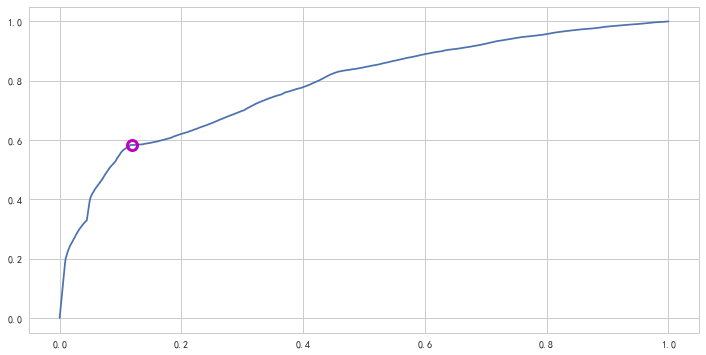

In [396]:
#ROC
from sklearn.metrics import roc_curve #ROC曲线
from sklearn.metrics import roc_auc_score #AUC分数

fpr_rf,tpr_rf,thresholds = roc_curve(y_test,model2.predict_proba(X_test)[:,1])

#找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds-0.5))
plt.figure(figsize=(12,6))
sns.set_style("whitegrid",{"font.sans-serif":["simhei","Arial"]})
plt.plot(fpr_rf,tpr_rf,label="ROC")
plt.plot(fpr_rf[close_zero],tpr_rf[close_zero],"o",markersize=10,label="threshold 0.5rf",fillstyle="none",c="m",mew=3)
#打印AUC分数
rf_auc = roc_auc_score(y_test,model2.predict_proba(X_test)[:,1])
print("模型精度:",rf_auc)

好坏客户区分度KS值: 0.467006438426


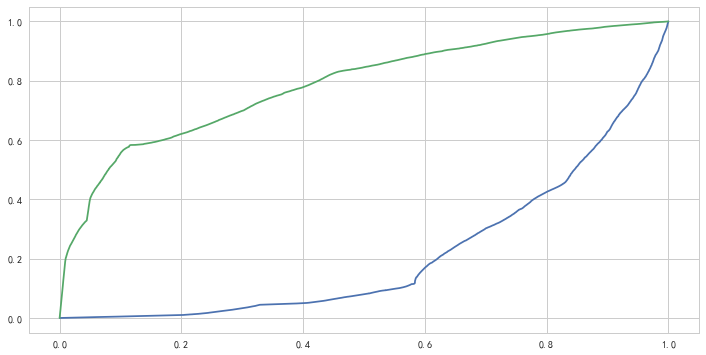

In [455]:
#KS值
KS=max(abs(fpr_rf-tpr_rf))
#ROC
from sklearn.metrics import roc_curve #ROC曲线
from sklearn.metrics import roc_auc_score #AUC分数

fpr_rf,tpr_rf,thresholds = roc_curve(y_test,model2.predict_proba(X_test)[:,1])

#找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds-0.5))
plt.figure(figsize=(12,6))
sns.set_style("whitegrid",{"font.sans-serif":["simhei","Arial"]})
plt.plot(tpr_rf,fpr_rf, label="KS")
plt.plot(fpr_rf,tpr_rf,label="KS")
#plt.plot(tpr_rf[close_zero],fpr_rf[close_zero],"o",markersize=10,label="threshold 0.5rf",fillstyle="none",c="m",mew=3)
#打印AUC分数
rf_auc = roc_auc_score(y_test,model2.predict_proba(X_test)[:,1])
print("好坏客户区分度KS值:",KS)

In [401]:
#输出特征系数
print(model2.intercept_)
print(model2.coef_)

[-0.0451483]
[[-1.55711183  0.29976425  2.45474657 -0.88762834 -0.75027511]]


In [402]:
#特征系数
coe = [-0.0451483,-1.55711183 ,0.29976425,2.45474657,-0.88762834,-0.75027511]

## 信用评分
### a=log（p_good/P_bad）
### Score = offset + factor * log(odds)

In [403]:
#取600分为基础分值，PDO为20（每高20分好坏比翻一倍），好坏比取20。 
p = 20/math.log(2)
q = 600 - 20 * math.log(20) / math.log(2)
baseScore = round(q + p *coe[0], 0)

In [434]:
baseScore

512.0

In [306]:
#计算分数函数
def get_score(coe,woe,factor):
    scores=[]
    for w in woe:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores

In [405]:
data.columns

Index(['X2', 'X5', 'X8', 'label', 'X9', 'X10'], dtype='object')

In [406]:
# 各项部分分数
X2 = get_score(coe[1],woe2,p)
X5 = get_score(coe[2],woe5,p)
X8 = get_score(coe[3],woe8,p)
X9 = get_score(coe[4],woe9,p)
X10 = get_score(coe[5],woe10,p)

In [432]:
cutx10

[0, 1]

In [433]:
X10

[12.0]

## 自动评分系统

In [448]:
df = pd.read_csv("data_new.csv",encoding="utf-8")
df.head()

,age,education,shebao,vehicle_num,income_range,loan_rate,seniority,client_type,label,zhima_score,gender_Female,gender_Male,marriage_marriage,marriage_unmarriage,house_nature_owned,house_nature_rent,house_nature_unknown,house_nature_with_parents,cv_ios,cv_other
0,33,2,1,0,4,0,4,1,0,781,0,1,0,1,1,0,0,0,0,1
1,24,3,0,0,1,1,1,2,0,705,1,0,0,1,0,1,0,0,0,1
2,40,2,1,0,4,1,2,2,0,798,0,1,1,0,1,0,0,0,0,1
3,35,1,1,0,4,1,4,2,0,676,0,1,1,0,1,0,0,0,0,1
4,24,2,0,0,2,1,1,2,0,753,1,0,0,1,0,1,0,0,0,1


In [451]:
#取出数据集的10%进行评分检验
df = df.sample(frac=0.1)
df[["education","income_range","client_type","gender_Female","zhima_score","label"]].to_excel("test_data.xlsx",index=False)

In [435]:
#根据变量计算分数
def compute_score(series,cut,score):
    list = []
    i = 0
    while i < len(series):
        value = series[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j >= 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list.append(score[m])
        i += 1
    return list

In [438]:
data.head()

,X2,X5,X8,label,X9,X10
0,-1.32700,-0.39300,1.59900,0,-1.89600,-0.54000
1,-1.32700,0.05600,1.59900,0,-0.58800,-0.54000
2,-1.32700,-0.39300,1.59900,0,-1.89600,-0.54000
3,-0.79000,-0.39300,1.59900,0,-0.58800,-0.54000
4,-1.32700,-0.03100,1.59900,0,-1.89600,-0.54000


In [439]:
df = data

In [440]:
df["X2"] = compute_score(list(data.X2),cutx2,X2)
df["X5"] = compute_score(list(data.X5),cutx5,X5)
df["X8"] = compute_score(list(data.X8),cutx8,X8)
df["X9"] = compute_score(list(data.X9),cutx9,X9)
df["X10"] = compute_score(list(data.X10),cutx10,X10)
df["Score"] = df["X2"] + df["X5"]+df["X8"]+df["X9"]+df["X10"]+baseScore

In [447]:
df.Score.value_counts()

731.00000    688431
730.00000     40172
Name: Score, dtype: int64

In [316]:
df.to_excel("test_score.xlsx",index=False)